In [1]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install shapely
!pip install scipy
!pip install hyperas

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (19.1.1)


In [2]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from shapely import wkb, wkt
from shapely.geometry import Point
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt
import random

from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV

from hyperas.distributions import uniform



# ----------- TODO: Issues with importing imbalance-learn library
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import NearMiss
# from imblearn.under_sampling import (RandomUnderSampler,
#                                      ClusterCentroids,
#                                      TomekLinks,
#                                      NeighbourhoodCleaningRule,
#                                      NearMiss)

Using TensorFlow backend.


In [3]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, ForeignKey, Float
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")

In [4]:
class GetData(object):
    def go(self, SESSION, start_year, end_year):
        SQL_QUERY = \
            f'''
                WITH
                    max_severity AS (
                        SELECT MAX(severity) AS severity
                        FROM (
                            SELECT SUM(crimetype.severity)/AVG(block.population) AS severity
                            FROM incident
                            INNER JOIN block ON incident.blockid = block.id INNER JOIN crimetype ON incident.crimetypeid = crimetype.id AND block.population > 0
                            GROUP BY
                                incident.blockid,
                                incident.year,
                                incident.month,
                                incident.dow
                        ) AS categories
                    ),
                    block_incidents AS (
                        SELECT
                            incident.blockid,
                            incident.year,
                            incident.month,
                            incident.dow,
                            SUM(crimetype.severity)/AVG(block.population) AS severity
                        FROM incident
                        INNER JOIN block ON incident.blockid = block.id
                        INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                            AND block.population > 0
                            AND incident.cityid = 1
                            AND incident.year >= {start_year}
                            AND incident.year <= {end_year}
                        GROUP BY
                            incident.blockid,
                            incident.year,
                            incident.month,
                            incident.dow
                    )
                SELECT
                    block_incidents.blockid,
                    block_incidents.year,
                    block_incidents.month,
                    block_incidents.dow,
                    block_incidents.severity/max_severity.severity AS severity
                FROM block_incidents, max_severity        
            '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [5]:
def process_data(data, start_year, end_year, blockid_dict):

    X = np.zeros((len(blockid_dict), 24, 7))
    y = np.zeros((len(blockid_dict), 12, 7))
    
    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12

    for r in data:
        if r[0] in blockid_dict:
            if r[1] == end_year:
                # index into array  0-based month
                # vvvvvvvvvvvvvvvv    vvvvvv
                y[blockid_dict[r[0]], r[2]-1, r[3]] = float(r[4])
                #                             ^^^^^^^^^^^^^   ^^^^
                #                             hours since     risk
                #                             beginning of
                #                             week
            else:
                # month, year = get_month_year(datetime)
                # index into array    year 0.....1   month   
                # vvvvvvvvvvvvvvvv    vvvvvvvvvvvvv  vvvvvv
                X[blockid_dict[r[0]], 12*(r[1]-start_year)+r[2]-1, r[3]] = float(r[4])
                #                                                  ^^^^^^^^^^^^^   ^^^^
                #                                                  hours since     risk
                #                                                  beginning of
                #                                                  week


    X = X * 1000
    y = y * 1000

    #     for i in range(24):
    #         X[:, i, -1] = (start_year*12+i) / (2000 * 12)
        
    return X, y

In [6]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data(training_start_year, training_end_year, train_blockid_dict,
               testing_start_year, testing_end_year, test_blockid_dict):
    with session_scope() as session:
        training_data = GetData().go(session,
                                     training_start_year,
                                     training_end_year)
        testing_data = GetData().go(session,
                                     testing_start_year,
                                     testing_end_year)
        
        X_train, y_train = process_data(training_data,
                                        training_start_year, 
                                        training_end_year,
                                        train_blockid_dict)
        X_test, y_test = process_data(testing_data,
                                      testing_start_year, 
                                      testing_end_year,
                                      test_blockid_dict)

    return X_train, X_test, y_train, y_test

In [9]:
%%time

# start month = 3, end_month = 2 (months are 0-indexed)
#   X: 4/2017 -> 3/2019 actual date
#   y: 4/2019 -> 3/2020 actual date
#
X_test_start_month = 0
X_test_end_month   = 0
X_test_start_year  = 2016
X_test_end_year    = 2018

TRAIN_NUM_BLOCKIDS = TEST_NUM_BLOCKIDS = 800

TRAIN_BLOCKIDS = random.sample(list(range(1,802)), k=TRAIN_NUM_BLOCKIDS)   
train_blockid_dict = {}
for ind, blockid in enumerate(TRAIN_BLOCKIDS ):
    train_blockid_dict[blockid] = ind
        
TEST_BLOCKIDS = random.sample(list(range(1,802)), k=TEST_NUM_BLOCKIDS)    
test_blockid_dict = {}
for ind, blockid in enumerate(TEST_BLOCKIDS ):
    test_blockid_dict[blockid] = ind

X_train, X_test, y_train, y_test = ready_data(2015, 2017, train_blockid_dict,
                                              X_test_start_year, X_test_end_year, test_blockid_dict)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


(800, 24, 7) (800, 12, 7) (800, 24, 7) (800, 12, 7)
CPU times: user 1.74 s, sys: 59 ms, total: 1.8 s
Wall time: 24.4 s


In [10]:
x_flat = X_test.flatten()
len(x_flat[x_flat > 0.0])

117609

In [11]:
len(x_flat[x_flat > 0.0])/len(x_flat)

0.8750669642857143

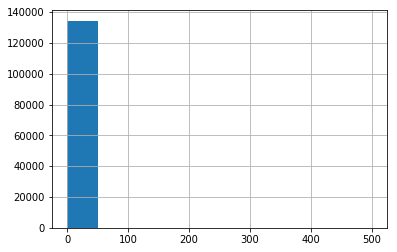

In [12]:
pd.Series(x_flat).hist()

In [13]:
pd.Series(x_flat).value_counts()

0.000000    16791
0.341880      115
0.535906      111
0.647249       99
0.472144       90
0.693001       82
0.464253       81
0.390549       79
1.618123       75
0.366300       74
0.267953       72
1.078749       72
0.857633       72
0.137826       70
0.944287       68
0.599520       66
0.289352       66
0.439754       64
0.582751       64
1.294498       63
0.291121       63
1.307190       62
0.393082       62
0.761035       62
0.416146       61
0.693481       61
0.571755       61
0.401929       60
0.268168       60
0.803859       60
            ...  
3.807418        1
2.367119        1
0.183251        1
3.533677        1
1.359690        1
1.777101        1
3.336068        1
4.423381        1
4.398021        1
3.592814        1
2.336722        1
1.517660        1
1.457372        1
1.789709        1
4.617414        1
3.405370        1
0.691460        1
3.233891        1
1.698420        1
1.544799        1
2.287378        1
1.085019        1
1.022181        1
1.447411        1
0.537792  

In [14]:
np.corrcoef(y_train.flatten(), y_test.flatten())

array([[ 1.        , -0.00529552],
       [-0.00529552,  1.        ]])

In [24]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape, Dropout, LeakyReLU, Bidirectional
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
import keras.backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from numpy.random import seed
from tensorflow import set_random_seed

seed(101)
set_random_seed(42)

best_model = None
best_mse   = None

def perc_error(y_true, y_pred):
    return 100.0 * K.mean((y_true - y_pred) / y_true)

def create_model(learn_rate=0.01, 
                 momentum=0,
                 opt_name='Adam',
                 init_mode='uniform',
                 activation='leakyrelu'
                ):
    
    if activation == 'leakyrelu':
        activation = LeakyReLU()
    
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    model.add(
        LSTM(168,
             input_shape=(24, 7),
             activation=LeakyReLU(),
             recurrent_activation=LeakyReLU(),
             dropout=0.2))
    model.add(Dropout(0.2))
    model.add(LeakyReLU(7))
    model.add(Dropout(0.5))
    model.add(Dense(12 * 7, activation='relu'))
    model.add(Reshape((12, 7)))
    
    optimizer = { 
        'SGD':      SGD(lr=learn_rate, momentum=momentum),
        'RMSprop':  RMSprop(lr=learn_rate),
        'Adagrad':  Adagrad(lr=learn_rate),
        'Adadelta': Adadelta(lr=learn_rate),
        'Adam':     Adam(lr=learn_rate),
        'Adamax':   Adamax(lr=learn_rate),
        'Nadam':    Nadam(lr=learn_rate),
    }

    def sqrt_loss(y_pred, y_true):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
    model.compile(loss='mean_absolute_error', metrics=[sqrt_loss], optimizer=optimizer[opt_name])

    return model

def my_gridsearch(X_train, y_train, X_test, y_test):
    
    # GridSearchCV's fit method requires X which is 2D, y which is 1D.
    # This is a problem for us since our X and y are 3D.
    # Instead of GridSearchCV, we will create our own loop to
    # search through the grid.
    
    global best_model, best_mse
    
    # 
    #     for epochs in range(5, 6, 5):
    #         for lr in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
    #             for opt_name in ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']:
    #                 for init_mode in ['uniform', 'lecun_uniform', 'normal', 'zero',
    #                                   'glorot_normal', 'glorot_uniform', 'he_normal',
    #                                   'he_uniform']:
    #                     for activation in ['relu']:
    batch_size = 64
    for epochs in range(10, 11, 5):
        for lr in [1e-3]:
            for opt_name in ['Adam']:
                for init_mode in ['uniform', 'lecun_uniform', 'zero']:
                    for activation in ['relu', 'leakyrelu']:

                        print('>'*80)
                        print('epochs:', epochs, '   lr:', lr, \
                              '   opt:', opt_name, \
                              '   init:', init_mode, \
                              '   act:', 'relu')
                        print('>'*80)

                        model = create_model(learn_rate=lr, 
                                             opt_name=opt_name,
                                             init_mode=init_mode,
                                             activation=activation)

                        history = model.fit(X_train, y_train,
                                            batch_size=batch_size, 
                                            epochs=epochs,
                                            validation_data=(X_test, y_test))

                        mse = model.evaluate(X_test, y_test,
                                             batch_size=batch_size)
                        if (best_mse is None) or \
                            (mse < best_mse):
                            best_mse = mse
                            best_model = model
                            print('best_model:', best_model)
                        
                        print('<'*80)
                        print('epochs:', epochs, \
                              '   lr:', lr, \
                              '   opt:', opt_name, \
                              '   init:', init_mode, \
                              '   act:', 'relu', \
                              ' Test MSE:', mse \
                        )
                        print('<'*80)

In [26]:
if model is not None:
    model.reset_states()

In [27]:
# my_gridsearch(X_train, y_train, X_test, y_test)

In [28]:
model = create_model(learn_rate=0.001)
# model.summary()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [29]:
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Train on 800 samples, validate on 800 samples
Epoch 1/10
800/800 [==============================] - 3s 4ms/step - loss: 37897759622.0008 - sqrt_loss: 528720121038.8615 - val_loss: 0.9362 - val_sqrt_loss: 1.8880
Epoch 2/10
800/800 [==============================] - 1s 1ms/step - loss: 0.9466 - sqrt_loss: 2.1737 - val_loss: 0.9362 - val_sqrt_loss: 1.8880
Epoch 3/10
800/800 [==============================] - 1s 1ms/step - loss: 0.9466 - sqrt_loss: 2.1619 - val_loss: 0.9362 - val_sqrt_loss: 1.8880
Epoch 4/10
800/800 [==============================] - 1s 1ms/step - loss: 0.9466 - sqrt_loss: 2.1768 - val_loss: 0.9362 - val_sqrt_loss: 1.8880
Epoch 5/10
800/800 [==============================] - 1s 1ms/step - loss: 0.9466 - sqrt_loss: 1.9756 - val_loss: 0.9362 - val_sqrt_loss: 1.8880
Epoch 6/10
800/800 [==============================] - 1s 1ms/step - loss: 0.9466 - sqrt_loss: 2.0446 - val_loss: 0.9362 - val_sqrt_loss: 1.8880
Epoch 7/10
800/800 [==============================] - 1s 1ms/step - l

In [30]:
def plot_output(y, y_pred, dataset_type):

    fig = plt.figure(figsize=(10, 8))
    plt.plot(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.plot(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red');
    plt.xlabel('Hour since beginning of data', fontsize=16)
    plt.ylabel('Risk', fontsize=18)
    plt.title(dataset_type + ' dataset', fontsize=18)
    plt.legend(labels=['risk', 'predicted risk'], prop={'size': 20})
    plt.show()

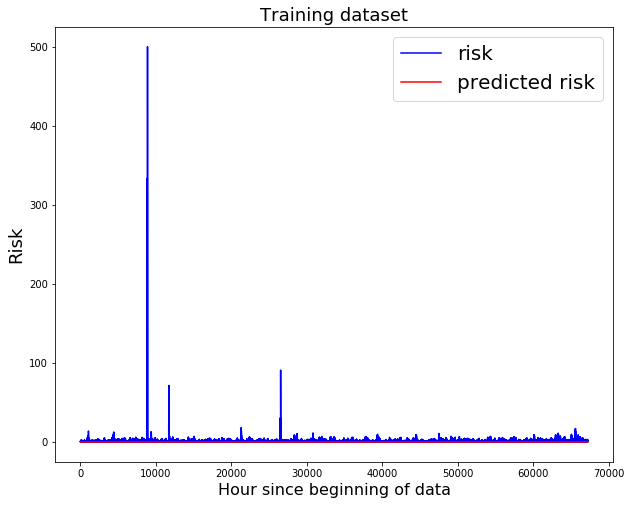

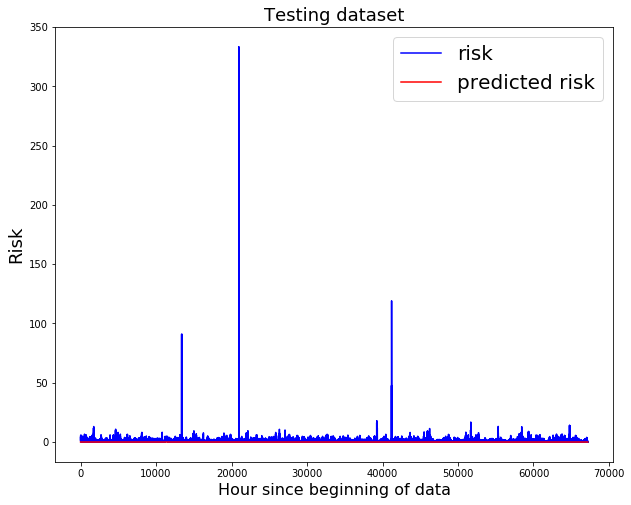

In [31]:
y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()

plot_output(y_train, y_train_pred, 'Training')
plot_output(y_test, y_test_pred, 'Testing')

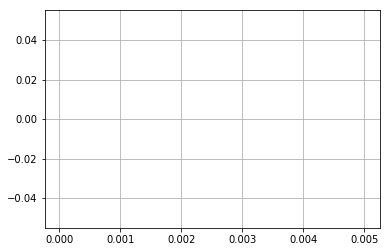

In [32]:
pd.Series(y_test_pred).hist(bins=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005])

In [33]:
pd.Series(y_test.flatten()).value_counts(normalize=True)

0.000000     0.130804
0.535906     0.000833
0.647249     0.000774
0.693001     0.000685
0.341880     0.000625
0.366300     0.000610
0.761035     0.000595
1.429388     0.000565
1.078749     0.000565
0.599520     0.000565
0.401929     0.000551
0.512821     0.000536
0.472144     0.000536
0.464253     0.000536
0.440335     0.000506
0.462321     0.000506
0.393082     0.000491
0.291121     0.000491
1.071811     0.000491
0.227687     0.000491
0.153116     0.000476
0.390549     0.000476
0.244200     0.000476
0.708215     0.000476
0.571755     0.000476
0.388500     0.000461
0.944287     0.000461
0.267953     0.000461
0.854701     0.000446
0.369959     0.000446
               ...   
1.452885     0.000015
5.640158     0.000015
1.390498     0.000015
6.622517     0.000015
1.777101     0.000015
0.843272     0.000015
1.167202     0.000015
0.564175     0.000015
1.022181     0.000015
1.015991     0.000015
4.250152     0.000015
2.232766     0.000015
2.059025     0.000015
1.497092     0.000015
1.084418  

In [34]:
pd.Series(y_test_pred.flatten()).value_counts(normalize=True)

0.0    1.0
dtype: float64